In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import glob
import calendar
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_selection import SelectFromModel

pd.options.display.max_columns = None
pd.options.display.max_rows = None

warnings.filterwarnings('ignore')

os.chdir("E:/Trinity/Dissertation/Sem 3/models/data/")

Read the new DataFrame

In [2]:
os.chdir("E:/Trinity/Dissertation/Sem 3/models/")
df = pd.read_csv("MoreCategoriesData.csv")  

In [5]:
df.head()

,Date,StartTime,EndTime,No_of_Cars,DayOfWeek,Weekend?,isHoliday?,Month,Day,Year,Tolls,Tollname_Dublin Tunnel,Tollname_Eastlink,Tollname_Limerick Tunnel,Tollname_M1,Tollname_M3,Tollname_M4,Tollname_M50,Tollname_M7-M8,Tollname_M8,Tollname_N25,Tollname_N6,ScaledStartTime,ScaledDayofWeek,TrafficCategory
0,01-01-2019,0,1,22,2,0,1,-1.552307,-1.676356,2019,M7-M8,0,0,0,0,0,0,0,1,0,0,0,-1.661325,-0.974781,1
1,01-01-2019,1,2,29,2,0,1,-1.552307,-1.676356,2019,M7-M8,0,0,0,0,0,0,0,1,0,0,0,-1.516862,-0.974781,1
2,01-01-2019,2,3,25,2,0,1,-1.552307,-1.676356,2019,M7-M8,0,0,0,0,0,0,0,1,0,0,0,-1.372399,-0.974781,1
3,01-01-2019,3,4,31,2,0,1,-1.552307,-1.676356,2019,M7-M8,0,0,0,0,0,0,0,1,0,0,0,-1.227936,-0.974781,1
4,01-01-2019,4,5,24,2,0,1,-1.552307,-1.676356,2019,M7-M8,0,0,0,0,0,0,0,1,0,0,0,-1.083473,-0.974781,1


In [4]:
df = df[df["Tolls"]!="--"]
df = df[df["No_of_Cars"]>15]


In [27]:
df["Tolls"].unique()

array(['M7-M8', 'N6', 'N25', 'M50', 'M1', 'M8', 'M3', 'Eastlink', 'M4',
       'Dublin Tunnel', 'Limerick Tunnel'], dtype=object)

In [133]:
df_Toll = df[df["Tolls"] == 'Limerick Tunnel']
df_Toll = df_Toll[["ScaledStartTime", "ScaledDayofWeek", "Day", "Month", "isHoliday?", "Weekend?", "No_of_Cars"]]

In [134]:
len(df_Toll)

5440

### MODEL

In [135]:
df_x = df_Toll.drop(["No_of_Cars"],axis=1)
df_y = df_Toll["No_of_Cars"]

In [136]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, train_size=0.80, random_state=100)

In [137]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=1500, random_state=100)

In [138]:
model = rf.fit(x_train, y_train)        # Fit the RFR mode

In [139]:
from sklearn.metrics import mean_squared_error, r2_score
ypred = model.predict(x_test)

In [140]:
import math

mse = mean_squared_error(y_test, ypred)
rmse = math.sqrt(mse)
rmse


71.81211396416091

In [141]:
data = pd.DataFrame(ypred, y_test).reset_index()

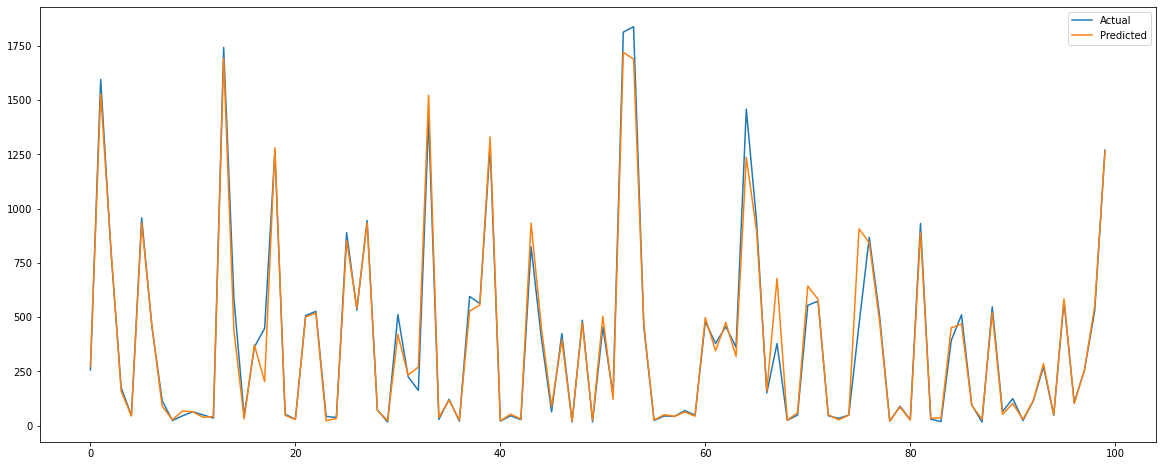

In [142]:
plt.figure(figsize=(20,8))
plt.plot(data["No_of_Cars"].head(100), label="Actual")
plt.plot(data[0].head(100), label="Predicted")
plt.legend(loc="upper right")
plt.show()

In [ ]:
test = pd.DataFrame(y_test)
pred = pd.DataFrame(ypred)
final = pd.concat([test, pred], axis=1)
test.to_csv("test.csv")
pred.to_csv("pred.csv")
# manually merge the CSVs

In [ ]:
data = pd.read_csv("test.csv")
data = data.set_index('Index')


In [ ]:
merged = pd.merge(left=df, left_index=True,
                  right=data, right_index=True,
                  how='inner')

In [ ]:
merged.head()

In [ ]:
final = merged[["Date","Tolls","StartTime","DayOfWeek","isHoliday?","No_of_Cars_y","Predicted"]]

final["Inaccuracy"] = abs(final["No_of_Cars_y"] - final["Predicted"])
final["Precision"] = final["Inaccuracy"]/final["No_of_Cars_y"]

final = final.sort_values("Precision", ascending=False)

#final[(final["Precision"]>1) & (final["No_of_Cars_y"]>10)]

In [ ]:
final.head()

In [ ]:
final.to_csv("RF_Predictions.csv", index=False)
#del(final)
del(test)
del(merged)
del(pred)
del(data)

In [ ]:
testing = final.reset_index()
plt.figure(figsize=(20,8))
plt.plot(testing[testing["Precision"]>=1].No_of_Cars_y, label="Actual")
plt.plot(testing[testing["Precision"]>=1].Predicted, label="Predicted")
plt.legend(loc="upper right")
plt.show()

In [ ]:
#testing = final.reset_index()
plt.figure(figsize=(20,8))
plt.plot(testing[testing["Precision"]<0.05].No_of_Cars_y.head(100), label="Actual")
plt.plot(testing[testing["Precision"]<0.05].Predicted.head(100), label="Predicted")
plt.legend(loc="upper right")
plt.show()

In [ ]:
testing[testing["Precision"]<1].head()

### Grid Search

In [ ]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [ ]:
grid_search.fit(x_train, y_train)
grid_search.best_params_

In [ ]:
'''
best_params = {'bootstrap': True,
 'max_depth': 80,
 'max_features': 3,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 1000}
 '''

In [ ]:
best_grid = grid_search.best_estimator_
model = best_grid.fit(x_train,y_train)

In [ ]:
predictions = model.predict(x_test)

In [ ]:
import math

mse = mean_squared_error(y_test, predictions)
rmse = math.sqrt(mse)
rmse

### Lazy Regressor

In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import datetime
import time
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.utils.testing import all_estimators
from sklearn.base import RegressorMixin
from sklearn.base import ClassifierMixin
from sklearn.metrics import accuracy_score, balanced_accuracy_score, roc_auc_score, f1_score, r2_score, mean_squared_error
import warnings
import xgboost
import lightgbm

warnings.filterwarnings("ignore")
pd.set_option("display.precision", 2)
pd.set_option("display.float_format", lambda x: '%.2f' % x)


REGRESSORS = [est for est in all_estimators(
) if issubclass(est[1], RegressorMixin)]

removed_regressors = [('TheilSenRegressor', sklearn.linear_model.theil_sen.TheilSenRegressor),
 ('ARDRegression', sklearn.linear_model.ARDRegression),
 ('CCA', sklearn.cross_decomposition.CCA),
 ('IsotonicRegression', sklearn.isotonic.IsotonicRegression),
 ('MultiOutputRegressor', sklearn.multioutput.MultiOutputRegressor),
 ('MultiTaskElasticNet',
  sklearn.linear_model.MultiTaskElasticNet),
 ('MultiTaskElasticNetCV',
  sklearn.linear_model.MultiTaskElasticNetCV),
 ('MultiTaskLasso', sklearn.linear_model.MultiTaskLasso),
 ('MultiTaskLassoCV',
  sklearn.linear_model.MultiTaskLassoCV),
 ('PLSCanonical', sklearn.cross_decomposition.PLSCanonical),
 ('PLSRegression', sklearn.cross_decomposition.PLSRegression),
 ('RadiusNeighborsRegressor',
  sklearn.neighbors.RadiusNeighborsRegressor),
 ('RegressorChain', sklearn.multioutput.RegressorChain),
 ('VotingRegressor', sklearn.ensemble.VotingRegressor),
 ('_SigmoidCalibration', sklearn.calibration._SigmoidCalibration),
 ('GaussianProcessRegressor',  sklearn.gaussian_process._gpr.GaussianProcessRegressor),
 ('KernelRidge', sklearn.kernel_ridge.KernelRidge),
 ('NuSVR', sklearn.svm._classes.NuSVR),
 ('MLPRegressor', sklearn.neural_network._multilayer_perceptron.MLPRegressor),
 ('OrthogonalMatchingPursuit', sklearn.linear_model._omp.OrthogonalMatchingPursuit),
 ('OrthogonalMatchingPursuitCV', sklearn.linear_model._omp.OrthogonalMatchingPursuitCV),
 ('PassiveAggressiveRegressor', sklearn.linear_model._passive_aggressive.PassiveAggressiveRegressor),
 ('SVR', sklearn.svm._classes.SVR)
]

for i in removed_regressors:
    REGRESSORS.pop(REGRESSORS.index(i))
    

REGRESSORS.append(('XGBRegressor', xgboost.XGBRegressor))
REGRESSORS.append(('LGBMRegressor',lightgbm.LGBMRegressor))
# REGRESSORS.append(('CatBoostRegressor',catboost.CatBoostRegressor))
    
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoding', OneHotEncoder(handle_unknown='ignore', sparse=False))
])



class LazyRegressor:
 
    def __init__(self, verbose=0, ignore_warnings=True, custom_metric = None, predictions = False,random_state=100):
        self.verbose = verbose
        self.ignore_warnings = ignore_warnings
        self.custom_metric = custom_metric
        self.predictions = predictions
        self.random_state = random_state

    def fit(self, X_train, X_test, y_train, y_test):

        R2 = []
        RMSE = []
        # WIN = []
        names = []
        TIME = []
        predictions = {}
        
        if self.custom_metric != None:
            CUSTOM_METRIC = []

        if type(X_train) is np.ndarray:
            X_train = pd.DataFrame(X_train)
            X_test = pd.DataFrame(X_test)

        numeric_features = X_train.select_dtypes(
            include=['int64', 'float64', 'int32', 'float32']).columns
        categorical_features = X_train.select_dtypes(
            include=['object']).columns

        preprocessor = ColumnTransformer(
            transformers=[
                ('numeric', numeric_transformer, numeric_features),
                ('categorical', categorical_transformer, categorical_features)
            ])
        
        print(REGRESSORS)
        for name, model in tqdm(REGRESSORS):
            start = time.time()
            try:
                if 'random_state' in model().get_params().keys():
                    pipe = Pipeline(steps=[
                        ('preprocessor', preprocessor),
                        ('regressor', model(random_state = self.random_state))
                    ])
                else:
                    pipe = Pipeline(steps=[
                    ('preprocessor', preprocessor),
                    ('regressor', model())
                ])
                pipe.fit(X_train, y_train)
                y_pred = pipe.predict(X_test)
                r_squared = r2_score(y_test, y_pred)
                rmse = np.sqrt(mean_squared_error(y_test, y_pred))
                names.append(name)
                R2.append(r_squared)
                RMSE.append(rmse)
                TIME.append(time.time() - start)
                if self.custom_metric != None:
                    custom_metric = self.custom_metric(y_test, y_pred)
                    CUSTOM_METRIC.append(custom_metric)

                if self.verbose > 0:
                    if self.custom_metric != None:
                        print({"Model": name,
                               "R-Squared": r_squared,
                               "RMSE": rmse,
                               self.custom_metric.__name__: custom_metric,
                               "Time taken": time.time() - start})
                    else:
                        print({"Model": name,
                               "R-Squared": r_squared,
                               "RMSE": rmse,
                               "Time taken": time.time() - start})
                if self.predictions == True:
                    predictions[name]=y_pred
            except Exception as exception:
                if self.ignore_warnings == False:
                    print(name + " model failed to execute")
                    print(exception)
                    
        if self.custom_metric == None:
            scores = pd.DataFrame({"Model": names, 
                                   "R-Squared": R2, 
                                   "RMSE": RMSE,
                                   "Time Taken": TIME})
        else:
            scores = pd.DataFrame({"Model": names, 
                                   "R-Squared": R2, 
                                   "RMSE": RMSE,
                                   self.custom_metric.__name__: CUSTOM_METRIC,
                                   "Time Taken": TIME})
        scores = scores.sort_values(
            by='R-Squared', ascending=False).set_index('Model')
        
        if self.predictions == True:
            predictions_df = pd.DataFrame.from_dict(predictions)
        return scores, predictions_df if self.predictions == True else scores

Regression = LazyRegressor


In [ ]:
from sklearn.utils import shuffle
X, y = shuffle(df_x, df_y, random_state=100)
X = X.astype(np.float32)
offset = int(X.shape[0] * 0.9)
X_train, y_train = X[:offset], y[:offset]
X_test, y_test = X[offset:], y[offset:]
reg = LazyRegressor(verbose=2,ignore_warnings=False, custom_metric=None )
models,predictions = reg.fit(X_train, X_test, y_train, y_test)

In [ ]:
models

### Find the inaccuracies

In [ ]:
data = pd.read_csv("RF_Predictions.csv")

In [ ]:
data.head()

In [ ]:
verybadpreds = data[data["Precision"]>0.5]

In [ ]:
verybadpreds["DayOfWeek"].value_counts()

In [ ]:
data["isHoliday?"].value_counts()

In [ ]:
print(176/7487)
print(24/165)

In [ ]:
len(verybadpreds[verybadpreds["isHoliday?"]==1])

### Each toll separately

In [ ]:
df.head()